In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('font', family='serif')

In [3]:
def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.
    
    Parameters
    ----------
    N : int 
        Length of the filter in samples.
    
    alpha: float
        Roll off factor (Valid values are [0, 1]).
    
    Ts : float
        Symbol period in seconds.
    
    Fs : float 
        Sampling Rate in Hz.
    
    Returns
    ---------
    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    
    time_idx : 1-D ndarray of floats 
        Array containing the time indices, in seconds, for 
        the impulse response.
        
    Source: https://github.com/muccc/iridium-toolkit/blob/master/extractor-python/filters.py
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)
        
    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)
        
    return time_idx, h_rrc

In [4]:
upsample = 100
Ns = 1000
fs = 22050
Rb = fs/upsample
L = 11
r = 0.5
fc = 4410

np.random.seed(0)
bit1 = 2*np.random.randint(0,2,Ns)-1
bit2 = 2*np.random.randint(0,2,Ns)-1

#pulso = np.ones(upsample)
t1,pulse = rrcosfilter(L*upsample,r,1/Rb,fs)

bit1_u = np.zeros(Ns*upsample)
bit1_u[::upsample] = bit1
PAM1 = np.convolve(bit1_u,pulse)

bit2_u = np.zeros(Ns*upsample)
bit2_u[::upsample] = bit2
PAM2 = np.convolve(bit2_u,pulse)

In [5]:
t = np.arange(PAM1.size)/fs
modulated1 = PAM1 * np.cos(2*np.pi*fc*t)
modulated2 = PAM2 * np.sin(2*np.pi*fc*t)
modulated = modulated1 - modulated2

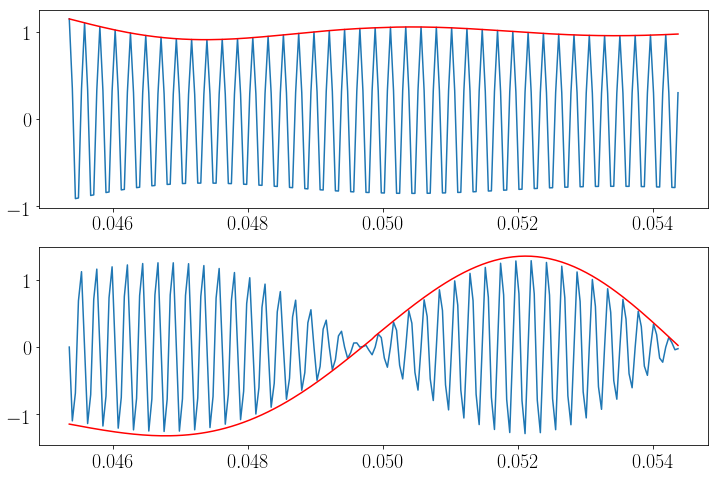

In [6]:
start = 1000
end = 1200

plt.subplot(2,1,1)
plt.plot(t[start:end],modulated1[start:end]);
plt.plot(t[start:end],PAM1[start:end],'r');

plt.subplot(2,1,2)
plt.plot(t[start:end],modulated2[start:end]);
plt.plot(t[start:end],PAM2[start:end],'r');

Before actually transmitting, let's play around with the receiver in an ideal situation, where the received signal is equal to the transmitted signal. In this case, the pulse is root-Nyquist, there is no channel, and we use a receive filter matched to the pulse. This means that the signal at the output of the receive is free from ISI at the sampling instants.

First, we verify that the seemingly-complicated demodulation model using the Hilbert transform and the complex exponential does what it is supposed to do: separating the two streams, generating an output that consists of PAM1 going through the receive filter, as if PAM2 did not exist, and another that consists of PAM2 going through the receive filter, as if PAM1 did not exist.

Note that there is a sign change in PAM2. This is because when complex numbers are used, the quadrature component (the one that multiplies the sine) ends up being multiplied by j twice, resulting in the sign change. This can easily be fixed. We can simply transmit $-b_k$ instead of $b_k$. 

In [7]:
received = modulated

In [8]:
t2 = np.arange(received.size)/fs
demodulated = signal.hilbert(received)*np.exp(-1j*2*np.pi*fc*t2)
filtered = np.convolve(demodulated,pulse)
QAM = PAM1 - 1j*PAM2
PAM1_expected = np.convolve(PAM1,pulse)
PAM2_expected = np.convolve(PAM2,pulse)

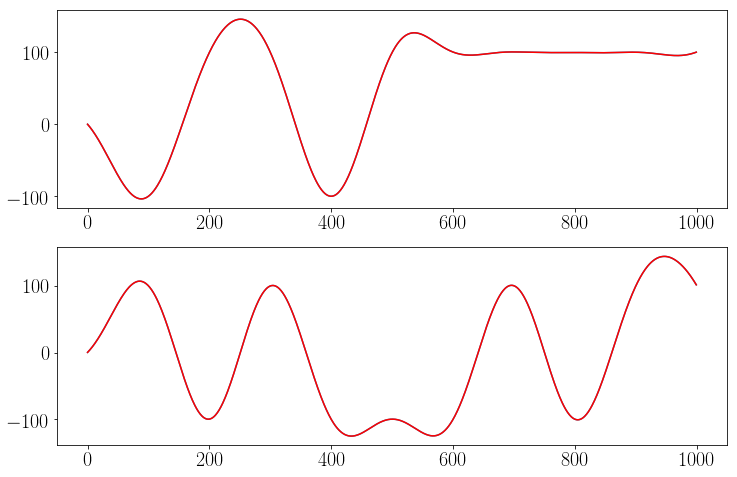

In [9]:
plt.subplot(2,1,1)
plt.plot(np.real(filtered[1000:2000]));
plt.plot(PAM1_expected[1000:2000],'r');

plt.subplot(2,1,2)
plt.plot(np.imag(filtered[1000:2000]));
plt.plot(PAM2_expected[1000:2000],'r');

What if there is a phase error in the receiver? As we will see, this rotates the estimated bits by an angle that is equal to the phase error.

In [10]:
t2 = np.arange(received.size)/fs
demodulated = signal.hilbert(received)*np.exp(-1j*2*np.pi*fc*t2)*np.exp(1j*np.pi/4)
filtered = np.convolve(demodulated,pulse)

In [11]:
demodulated_expected = signal.hilbert(modulated)*np.exp(-1j*2*np.pi*fc*t2)
filtered_expected = np.convolve(demodulated_expected,pulse)

In this case, the two filtered signals are no close to either of the expected streams.

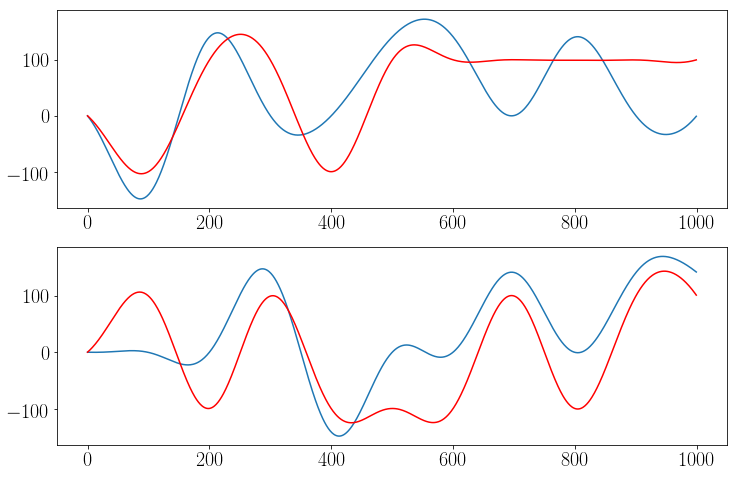

In [12]:
plt.subplot(2,1,1)
plt.plot(np.real(filtered[1000:2000]));
plt.plot(np.real(filtered_expected[1000:2000]),'r');

plt.subplot(2,1,2)
plt.plot(np.imag(filtered[1000:2000]));
plt.plot(np.imag(filtered_expected[1000:2000]),'r');

Still, as we see below, the eye diagram looks promising. There are some points that seem free from ISI, even though at these points there are three possible values where we would expect only two.

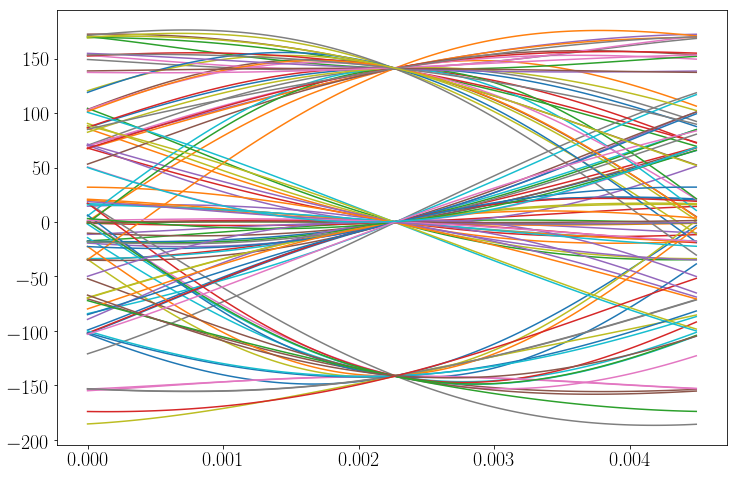

In [13]:
t = np.arange(upsample)/fs
delay = 1050
Ns_show = 100
eye = np.real(filtered)[delay:(delay+Ns_show*upsample)].reshape(upsample,Ns_show,order='F');
plt.plot(t,eye);

Let's sample anyway and see if we can figure something out. We'll plot the decisions in the complex plane. Obviously, we will sample at the instants where the eye is most open. As we see below, the sampler outputs are equal to the transmitted complex symbol, rotated by $\pi/4$.

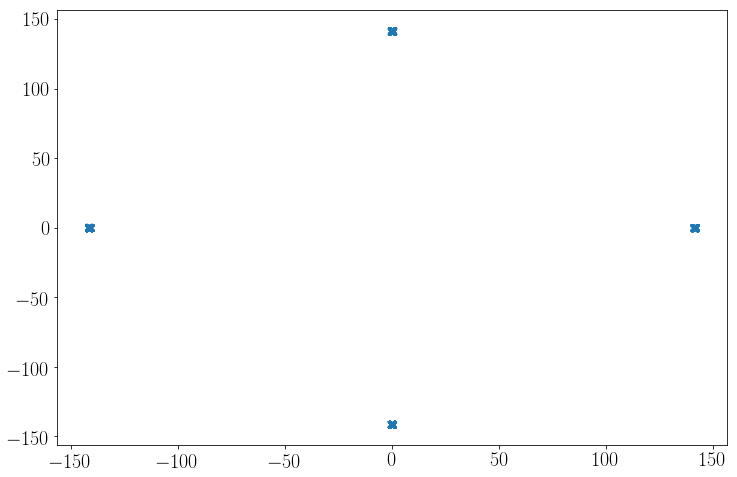

In [14]:
delay = pulse.size
bits_ = filtered[delay:delay + upsample*Ns:upsample]
plt.plot(np.real(bits_),np.imag(bits_),'x');

What if there is a phase error is not constant? This models a situation where the frequency of the carrier at the receiver is $f_c + \Delta_f$, where $f_c$ is the carrier frequency and $\Delta_f$ is the frequency error at the receiver. 

As before, this rotates the estimated bits by an angle that is equal to the phase error. But now the phase error is time-varying, of the form $\theta + \Delta_f t$, where $\theta$ is the phase error. This means that the rotation increases with time.

In [15]:
theta = np.pi/4
Df = 1
t2 = np.arange(received.size)/fs
demodulated = signal.hilbert(received)*np.exp(-1j*2*np.pi*fc*t2)*np.exp(1j*(theta + 2*np.pi*Df*t2))
#demodula = recebido*np.cos(2*np.pi*4500*t2)
filtered = np.convolve(demodulated,pulse)

This time, the eye diagram does not look as promising. 

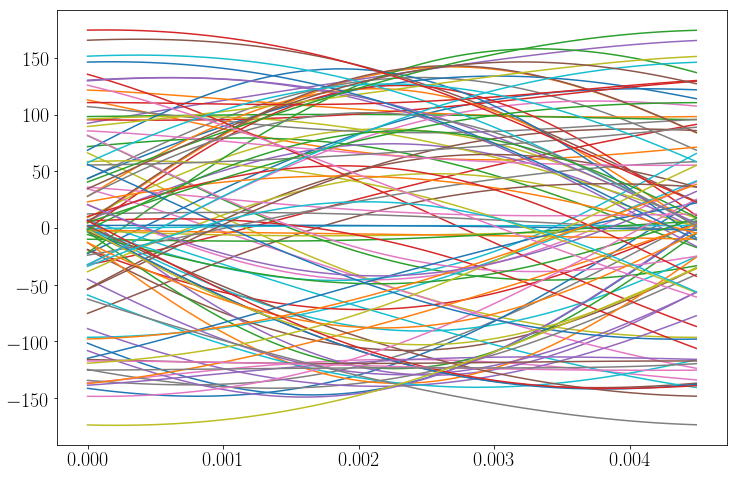

In [16]:
t = np.arange(upsample)/fs
delay = 1050
Ns_show = 100
eye = np.real(filtered)[delay:(delay+Ns_show*upsample)].reshape(upsample,Ns_show,order='F');
plt.plot(t,eye);

Still, a 2D plot shows the expected: a time-varying rotation.

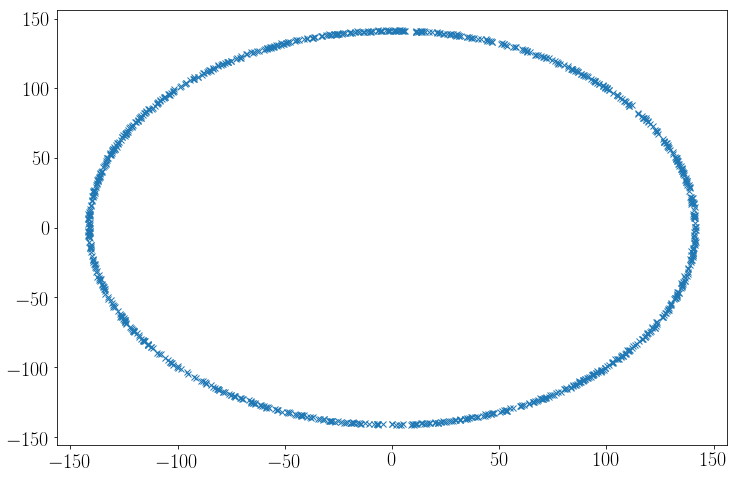

In [17]:
delay = pulse.size
bits_ = filtered[delay:delay + upsample*Ns:upsample]
plt.plot(np.real(bits_),np.imag(bits_),'x');

To further highlight that this is a rotation of the transmitted symbol by a progressively larger angle, we plot only the bit estimates when the transmitted bits are +1 in both streams. Then we plot the rotation angle versus k, the time-index of the bit.

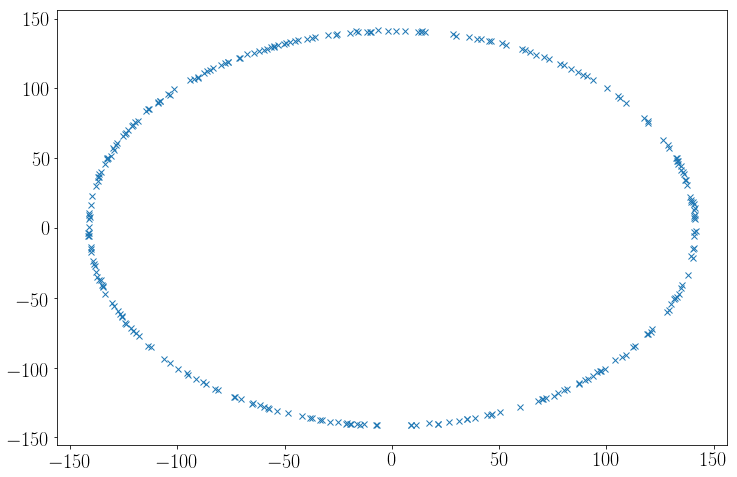

In [18]:
delay = pulse.size
bits_ = filtered[delay:delay + upsample*Ns:upsample]
index = np.where(np.logical_and(bit1==1, bit2==1))
plt.plot(np.real(bits_[index]),np.imag(bits_[index]),'x');

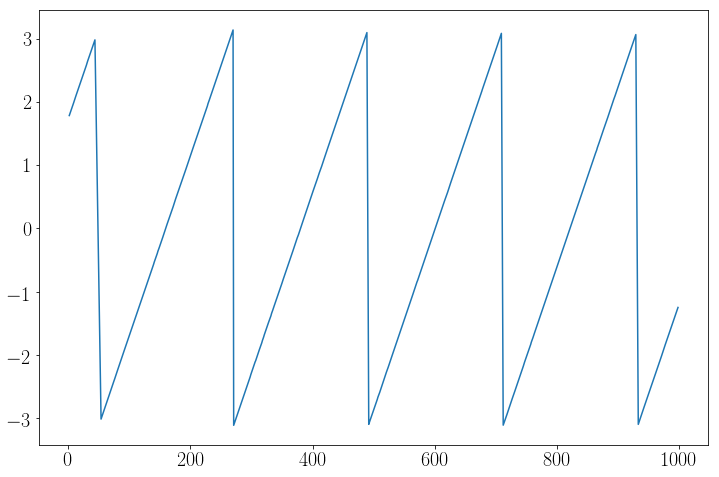

In [19]:
plt.plot(np.asarray(index).flatten(),np.angle(bits_[index]));

Note how the phase increases linearly with time. This is consistent to what we would expect from theory: the continuous-time phase error is $\exp(\theta + 2\pi \Delta_f t)$. The rotation is the value of the phase error at the $n$-th symbol instant: $\exp(\theta + 2\pi \Delta_f n / R_b)$. In our case, $\Delta_f = 1$, $R_b = 220.5$, so we expect the phase to change by $2\pi$ roughly every 220 samples. Which is what the figure above shows us.

We are now ready to save the modulated signal, play it, and record.

In [5]:
sf.write('tx_qam.wav', modulated, fs)

In [59]:
received, fs = sf.read('rx_qam.wav')
modulated, fs = sf.read('tx_qam.wav')

First, we bring the received signal back to baseband and pass it through the matched filter

In [60]:
t2 = np.arange(received.size)/fs
demodulated = signal.hilbert(received)*np.exp(-1j*2*np.pi*fc*t2)
filtered = np.convolve(demodulated,pulse)

How does it look? Let's first check the eye diagram. But let's not forget that in baseband a bad eye diagram may simply mean that there is a problem in the carrier phase and/or frequency, which as we will see should be easy to fix. Anyway, we firt try to determine the beginning of the reception, to focus the eye diagram on the time range where we are actually receiving data.

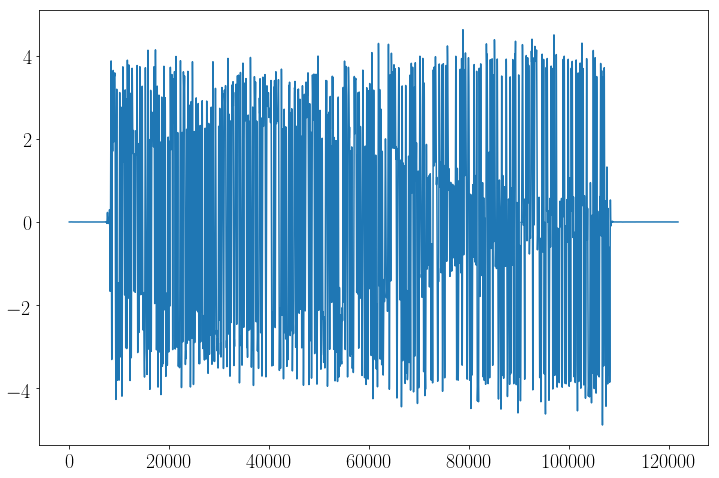

In [61]:
plt.plot(filtered.real);

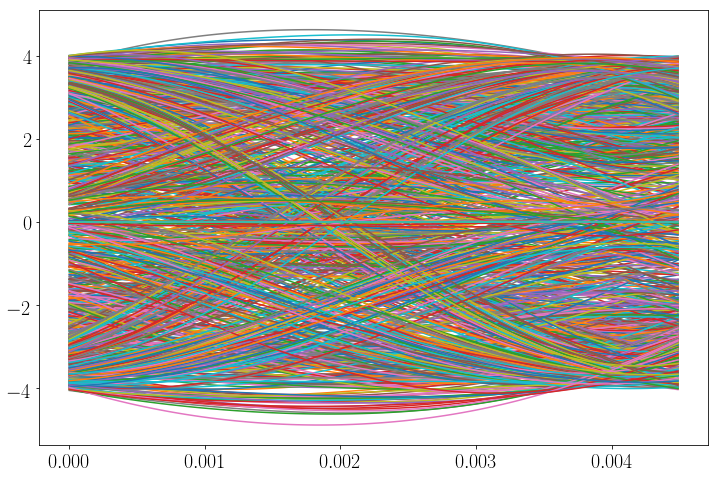

In [17]:
begin = 10000
end = 110000
tteste = np.arange(upsample)/fs
eye = filtered.real[begin:end].reshape(upsample,Ns,order='F');
plt.plot(tteste,eye);

Not that great. Let's continue, and hope that it is just a problem with the phase. To synchonize, we first generate what we would expect to see at the output of the matched filter, and correlate that to what we actually see. Note that the quadrature component is subtracted, not added. This is due to a small quirk in the relationship between the actual 

In [64]:
filtered_expected = np.convolve(pulse,PAM1 - 1j * PAM2)
synch = np.correlate(filtered, filtered_expected,mode='full')

In the next figure, we see a nice spike in correlation, indicating that we can be pretty sure that the spike position corresponds to the last sample of a good alignment between `filtered` and `filtered_expected`. This gives us reason to be hopeful that the system will work, despite the bad eye diagram above.

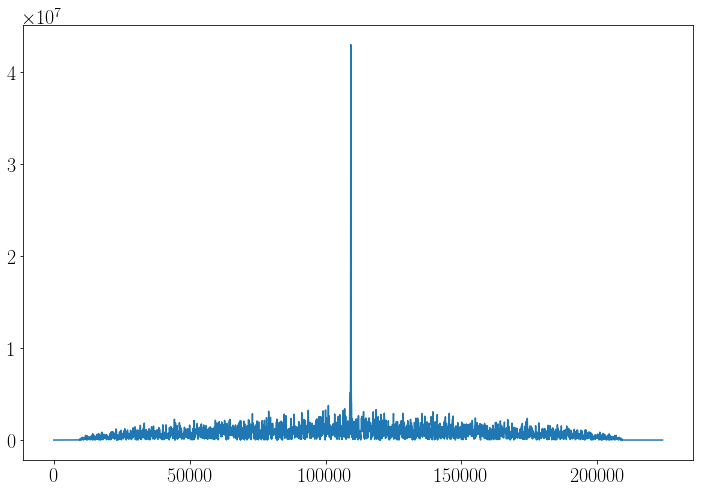

In [65]:
plt.plot(np.abs(synch));

The correlation may help us obtain a rotated version of `filtered` that is most aligned with `filtered_expected`. Obviously, to determine this rotation, we assume we know what `filtered_expected` is. In a practical system, we would transmit first some known symbols, do the procedure below, then apply the resulting rotation to the next transmitted symbols, which contain actual information are thus are not known at the receiver.

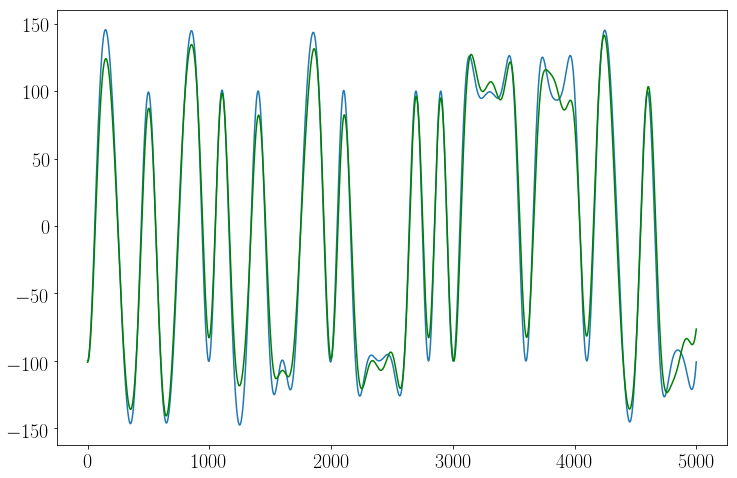

In [66]:
delay = np.abs(synch).argmax()
d = delay - int(filtered_expected.size)
filtered_rotated = filtered * synch[delay]/np.linalg.norm(filtered)**2
plt.plot(filtered_expected.real[10000:15000]);
plt.plot(filtered_rotated.real[d+10000:d+15000],'g');

Looks very good. Let's see if the eye diagram is better. The first one uses 200 intervals at the beginning of the transmission. The second uses 200 intervals at the end. Clearly, things get worse as time progress, indicating that the rotation is actually time-varying. This, in turn, indicates an error in the carrier frequency, which would require better phase recovery algorithms.

Note that we used the same digital frequency for both the transmission and the reception. Any phase difference is thus due to differences in the sampling rate.

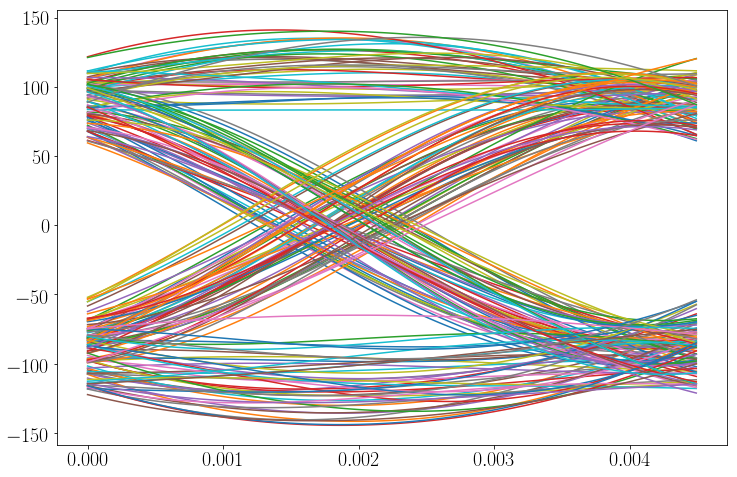

In [34]:
Ns_show = 200
begin = 10000
end = begin + Ns_show * upsample
tteste = np.arange(upsample)/fs
eye = filtered_rotated.real[begin:end].reshape(upsample,Ns_show,order='F');
plt.plot(tteste,eye);

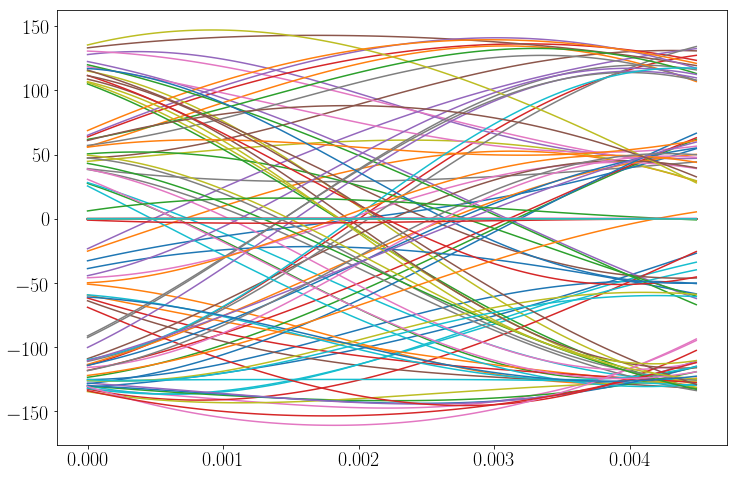

In [35]:
Ns_show = 200
begin = 100000
end = begin + Ns_show * upsample
tteste = np.arange(upsample)/fs
eye = filtered_rotated.real[begin:end].reshape(upsample,Ns_show,order='F');
plt.plot(tteste,eye);

Moving on, let's make some decisions, and plot these in the complex plane. As expected, the bits rotate, indicating an error in the carrier frequency. You may think that the fact that there are four distinct regions that do not overlap is important. However, this only happens because the number of symbols is too small. With more symbols, the samples would keep rotating and the regions would overlap.

On the other hand, note how the amplitudes do not change much, indicating low noise levels.

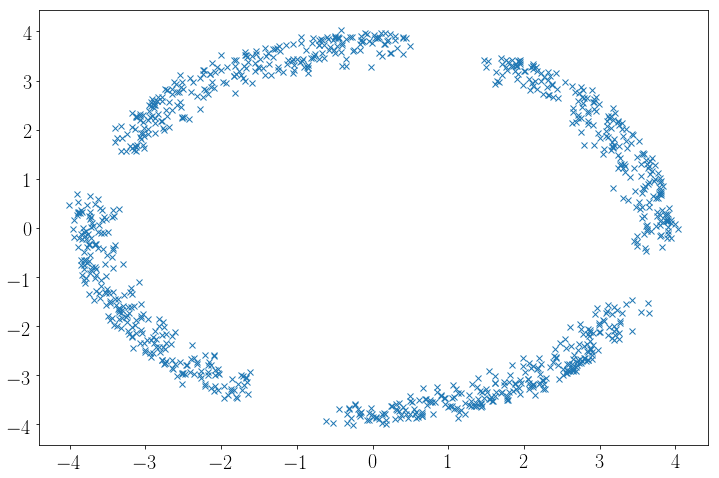

In [67]:
final_d = d + pulse.size
bits_ = filtered[final_d:final_d + upsample*Ns:upsample]
plt.plot(bits_.real,bits_.imag,'x');

How do we fix the rotation? There are many powerful techniques available, including a digital PLL. And certainly one of them should be applied. However, in this very simple case, there is a quick and dirty solution. We assume that the first symbol is known, and we compare it to the first sample. This should give us an initial value for the rotation, and we rotate the whole sequence by that amount

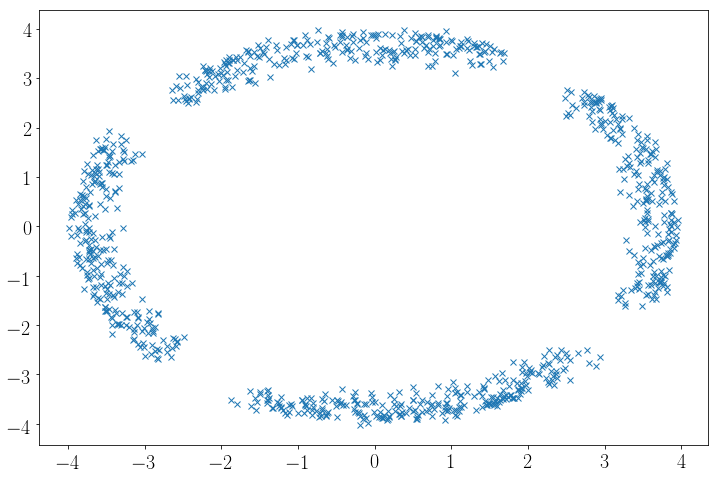

In [68]:
bits = bit1 - 1j*bit2
bits_ = bits_*np.exp(-1j*np.angle(bits_[0]/bits[0]))
plt.plot(bits_.real,bits_.imag,'x');

Clearly, this initial rotation does not fix the problem. But it should be good enough for us to make a decent decision on the second sample. 

If we assume that this decision is correct, we can repeat the procedure above for the remaining symbols, using the decision instead of the actual and unknown value of `bits[1]`.

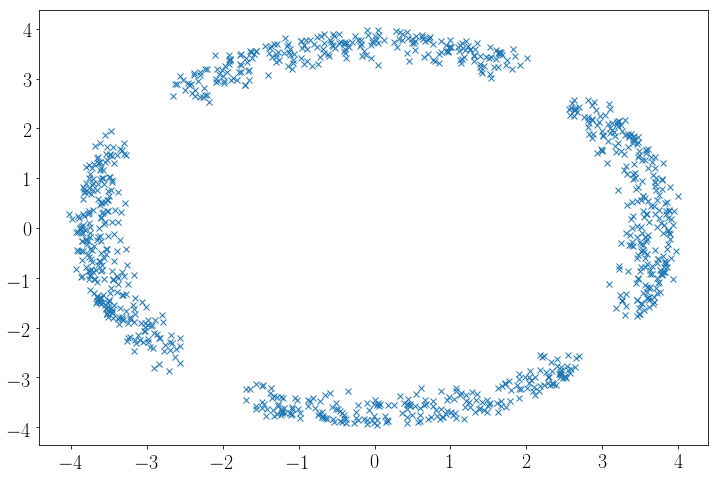

In [40]:
decision = np.zeros(bits.size) + 1j*np.zeros(bits.size)
decision[0] = bits[0]  #this is known
decision[1] = np.sign(bits_[1].real) - 1j*np.sign(bits_[1].imag)
bits_[1:] = bits_[1:]*np.exp(-1j*np.angle(bits_[1]/decision[1]))
plt.plot(bits_.real,bits_.imag,'x');

We can now repeat this procedure for all the remaining samples. To make the code simpler, we start the process over from the beginning.

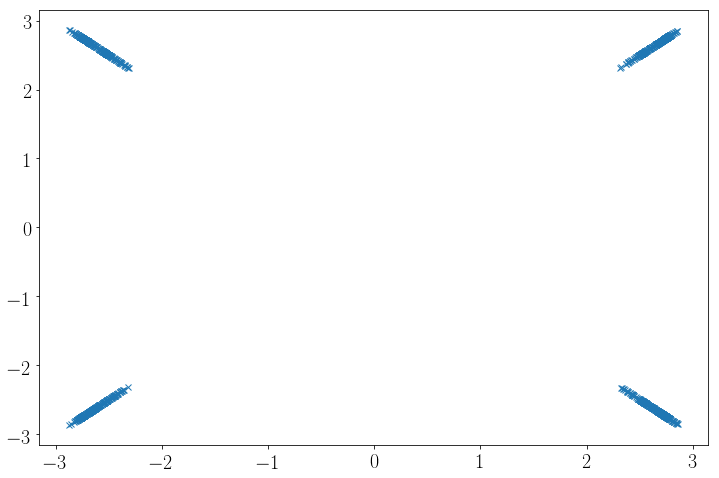

In [72]:
bits_ = filtered[final_d:final_d + upsample*Ns:upsample]
decision = np.zeros(bits.size) + 1j*np.zeros(bits.size)
angles = np.zeros(bits.size)
decision[0] = bits[0]  #this is known
bits_ = bits_*np.exp(-1j*np.angle(bits_[0]/decision[0]))
angles[0] = np.angle(bits_[0]/decision[0])
for ii in range(1,Ns):
    decision[ii] = np.sign(bits_[ii].real) + 1j*np.sign(bits_[ii].imag)
    angles[ii] = np.angle(bits_[ii]/decision[ii])
    bits_[ii:] = bits_[ii:]*np.exp(-1j*angles[ii])
plt.plot(bits_.real,bits_.imag,'x');

Now let's check the number of errors.

In [75]:
print(np.linalg.norm(decision-bits))

0.0


Yay! No errors again.